# Data Loading


In [ ]:
# download udacity dataset
!gdown 1o0zVihb6j_G3N2l6lmvZCyi-yI-HwgS4
!unzip svm_train.zip -d data_test
!mv data_test/data data
!mv data/feature.py feature.py
!rm -r data_test
!rm svm_train.zip

In [9]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from features import *

In [2]:
from importlib import reload

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Convert Cto YCrCb color
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Train SVM

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from copy import copy
import time

In [12]:
# Read in cars and notcars
carpics = glob.glob('data/vehicles/*.png')
notcarpics = glob.glob('data/non-vehicles/*.png')
cars = []
notcars = []
for image in carpics:
    cars.append(image)
for image in notcarpics:
    notcars.append(image)

In [6]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6696
10.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


In [8]:
model_pickle = {}
model_pickle['svc'] = svc
model_pickle['scaler'] = X_scaler
model_pickle['orient'] = orient
model_pickle['pix_per_cell'] = pix_per_cell
model_pickle['cell_per_block'] = cell_per_block
model_pickle['spatial_size'] = spatial_size
model_pickle['hist_bins'] = hist_bins
pickle.dump( model_pickle, open( "svm.pkl", "wb" ))

# Single Frame Detection

In [ ]:
img = mpimg.imread('test_images/test4.jpg')

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
              , videoProcess=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = int(xleft*scale)
                ytop_draw = int(ytop*scale)
                win_draw = int(window*scale)
                
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                if not videoProcess:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    heatmap = add_heat(heat, bboxes)          
    
    return heatmap, draw_img


<ipython-input-37-52bd1c77475e>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  heat = np.zeros_like(img[:,:,0]).astype(np.float)


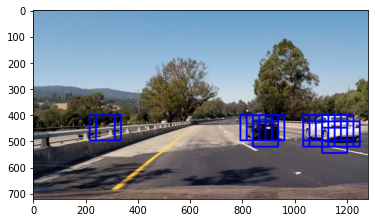

In [ ]:
    
ystart = 400
ystop = 656
scale = 1.5
    
_, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                       videoProcess=False)

plt.imshow(out_img);

# Video Detection

In [14]:
from scipy.ndimage.measurements import label
%matplotlib inline

<ipython-input-14-4b3dc56db5a7>:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    box_list = []
    
    # Iterate through all detected cars
    # labels[0]: img ndarray with value={label_num}
    # labels[1]: num_features
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        # one rectangular box
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        # could be [0,255] or [0,1] depending how the file was read in
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
        
        box_list.append(bbox)

    return img, box_list

In [16]:
def track_vehicles(img, frame_bound=3):
    
    global draw_img_prev, bbox_list_prev, labels_prev, heatmap_sum
    global first_frame, frame_count

    # use a 3-frame sequence to detect cars in a video
    # use heatmap_sum to store cumulative bboxes from frames + scales 
    # use threshold and label to identify one bbox per unique car
    # reset every 3 frames.
    
    model_pickle = pickle.load(open('00-training.pkl', 'rb'))
    svc = model_pickle['svc']
    X_scaler = model_pickle['scaler']
    orient = model_pickle['orient']
    pix_per_cell = model_pickle['pix_per_cell'] 
    cell_per_block = model_pickle['cell_per_block']
    spatial_size = model_pickle['spatial_size']
    hist_bins = model_pickle['hist_bins']
    
    #this could be changed relative to image size
    ystart = 400
    ystop = 420
    
    # first frame out of 3-frame sequence, draw cars
    if first_frame:
        
        #initialize the running average heatmap
        heatmap_sum = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # repeat three scales because we don't know how large each car could be w.r.t. the image
        # amplify detected bbox regions
        for scale in (1.0,1.5,2.0):
            
            #as the image scale gets bigger, the ROI needs to extend
            ystop = ystop + 75

            # heatmap: (img_h, img_w, 0 or {num}) multiple bboxes identified from a single image 
            # bbox: window size*scale
            heatmap, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                        pix_per_cell, cell_per_block, spatial_size, hist_bins)
            #sum up heatmap for all scales
            heatmap_sum = np.add(heatmap_sum,heatmap)
        
        heatmap = apply_threshold(heatmap_sum, 2) # at least two overlapping occurance.
        heatmap = np.clip(heatmap, 0, 1)
        labels = label(heatmap) # (label, num_features), assign different number to connected features (cross style)
        draw_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels) # draw one box for each feature/car

        draw_img_prev = draw_img
        bbox_list_prev = bbox_list
        labels_prev = labels

        first_frame = False
    
        return draw_img
    
    # 2nd, 3rd frame out of 3-frame sequence, update heatemap only
    if frame_count <= frame_bound: # 3
        
        frame_count += 1
        
        #reset ROI
        ystop = 420
        
        for scale in (1.0,1.5,2.0):

            ystop = ystop + 75
            heatmap, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            heatmap_sum = np.add(heatmap_sum,heatmap)
            draw_img = np.copy(img)
        
        #draw old boxes from the first frame
        for unique_car in range(1, labels_prev[1]+1):
            draw_img = cv2.rectangle(draw_img, bbox_list_prev[unique_car-1][0],
                                     bbox_list_prev[unique_car-1][1], (255,0,0), 6)
        return draw_img
    
    # 4th frame / start a new 3-frame sequence
    heatmap = apply_threshold(heatmap_sum,2)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)   
    draw_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels)   
    
    draw_img_prev = draw_img
    bbox_list_prev = bbox_list
    labels_prev = labels
    
    #reset heatmap sum and frame_count
    heatmap_sum = np.zeros_like(img[:,:,0]).astype(np.float)
    frame_count = 0
    
    return draw_img

In [23]:
%%capture

!gdown 1LduALiAiIoaN-6Gz-wyq-xI2pKyBi3ES
!unzip -o test_images.zip -d test_images
!mv test_images/test_images custom_test
!rm -r test_images

In [22]:
!rm -r custom_test

In [24]:
import glob
images = glob.glob('custom_test/*jpg')
for index, image in enumerate(images):
    
    img = mpimg.imread(image)
    global first_frame, frame_count

    # force treating every image as a new frame sequence.
    frame_count = 0 
    first_frame = True
    draw = track_vehicles(img)
    
    plt.figure()
    plt.imshow(draw);
    plt.tight_layout()
    plt.savefig('output_images{}'.format(index))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

global first_frame, frame_count
frame_count = 0
first_frame = True

project_video_output = 'combined_pipeline.mp4'
clip2 = VideoFileClip('processed-project_video.mp4')

project_video_clip = clip2.fl_image(track_vehicles)
%time project_video_clip.write_videofile(project_video_output, audio=False, verbose=False)

video = 'combined_pipeline.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))